# MIMIC: Mortality Prediction with ICD Hyperbolic Embedding Features
by: Drew Wilimitis <br>

**Purpose:** Test the effect of using hyperbolically embedded ICD code features in the mortality prediction problem.<br>

**Outline:**

Part A: Training Embeddings <br>
1. Build co-occurrence relations based on combinations of icd codes listed within each hospital admission <br>
2. Train embeddings of icd codes in poincare disk <br>
3. Use the co-occurrence relations and train euclidean embeddings with word2vec and GloVe algorithms <br>
4. Evaluate and compare embeddings with distance ratios and other metrics

Part B: Clustering <br>
1. Fit hyperbolic k-means to poincare embeddings and compare to euclidean clustering (on poincare and euclidean embeddings) <br>
2. Evaluate unsupervised clustering performance and compare mortality/other variables across clusters <br>

Part C: Mortality Prediction <br>
1. Define sensible features and pre-process data for prediction task <br>
2. Train models and analyze performance effect of using euclidean vs. hyperbolic embedding features <br>

Note: For euclidean embeddings, reference https://arxiv.org/pdf/1804.01486.pdf <br>

Note: Also compare to https://github.com/brettbj/PoincareEmbeddings

## Importing Libraries and Loading Data

In [40]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import networkx as nx
import sys
import os
import json

# import locally stored library
sys.path.append('/Users/drew/Desktop')
sys.path.append('/Users/drew/Desktop/vu_informatics')
from icd9 import icd9

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [41]:
adm = pd.read_csv('data/mimic-iii/ADMISSIONS.csv')
adm.head()
adm.shape
adm[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS']].nunique()
adm[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS']].isna().sum()
adm['ADMISSION_TYPE'].value_counts() / adm.shape[0]
adm['HOSPITAL_EXPIRE_FLAG'].mean()
adm['HAS_CHARTEVENTS_DATA'].mean()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


(58976, 19)

SUBJECT_ID    46520
HADM_ID       58976
DIAGNOSIS     15691
dtype: int64

SUBJECT_ID     0
HADM_ID        0
DIAGNOSIS     25
dtype: int64

EMERGENCY    0.713358
NEWBORN      0.133325
ELECTIVE     0.130663
URGENT       0.022653
Name: ADMISSION_TYPE, dtype: float64

0.09926071622354857

0.9730059685295713

In [42]:
icu = pd.read_csv('data/mimic-iii/ICUSTAYS.csv')
icu.head()
icu.shape
icu[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']].nunique()
icu[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']].isna().sum()
icu['LOS'].mean()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


(61532, 12)

SUBJECT_ID    46476
HADM_ID       57786
ICUSTAY_ID    61532
dtype: int64

SUBJECT_ID    0
HADM_ID       0
ICUSTAY_ID    0
dtype: int64

4.91797158089793

In [43]:
ref_icd = pd.read_csv('data/mimic-iii/D_ICD_DIAGNOSES.csv')
ref_icd.head()
ref_icd.shape
icd_code_to_name = dict(zip(ref_icd.ICD9_CODE.values, ref_icd.SHORT_TITLE.values))

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


(14567, 4)

In [44]:
diag = pd.read_csv('/Users/drew/Downloads/DIAGNOSES_ICD.csv.gz', compression='gzip')
diag.head()
diag.shape
diag[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].nunique()
diag[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].isna().sum()
diag[['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']].groupby(['HADM_ID', 'SUBJECT_ID'])['ICD9_CODE'].count().mean()
diag[['SUBJECT_ID', 'ICD9_CODE']].groupby(['SUBJECT_ID'])['ICD9_CODE'].count().mean()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


(651047, 5)

SUBJECT_ID    46520
HADM_ID       58976
ICD9_CODE      6984
dtype: int64

SUBJECT_ID     0
HADM_ID        0
ICD9_CODE     47
dtype: int64

11.038388497015735

13.993981083404988

In [45]:
patients = pd.read_csv('/Users/drew/Desktop/vu-informatics/data/mimic-iii/PATIENTS.csv')
patients.head()
patients.shape
patients['GENDER'].value_counts() / patients.shape[0]
adm_dem = patients.merge(adm[['SUBJECT_ID', 'ADMITTIME', 'ETHNICITY']], on='SUBJECT_ID')
adm_dem.shape
adm_dem['ETHNICITY'].value_counts()[:5] / adm_dem.shape[0]
adm_dem['AGE_AT_ADMIT'] = pd.to_numeric(adm_dem['ADMITTIME'].apply(lambda x: x[:4])) - pd.to_numeric(adm_dem['DOB'].apply(lambda x: x[:4]))
adm_dem['AGE_AT_ADMIT'].mean()
adm_dem['AGE_AT_ADMIT'].describe()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


(46520, 8)

M    0.5615
F    0.4385
Name: GENDER, dtype: float64

(58976, 10)

WHITE                     0.695130
BLACK/AFRICAN AMERICAN    0.092241
UNKNOWN/NOT SPECIFIED     0.076692
HISPANIC OR LATINO        0.028757
OTHER                     0.025638
Name: ETHNICITY, dtype: float64

64.4303954150841

count    58976.000000
mean        64.430395
std         57.201559
min          0.000000
25%         43.000000
50%         62.000000
75%         76.000000
max        311.000000
Name: AGE_AT_ADMIT, dtype: float64

## Extract ICD Co-occurrence Relations and Embed in Hyperbolic Space

In [46]:
# store each admissions code list
icd_dict = {}

# within each admission, define edges for each combination of codes (u, v) with increasing sequential numbers
edges = []
for hadm_id in diag.HADM_ID.unique():
    icd_list = list(diag[diag.HADM_ID == hadm_id]['ICD9_CODE'].values)
    icd_dict[hadm_id] = icd_list
    for i in range(len(icd_list)-1):
        for j in range(i+1, len(icd_list)):
            if len(icd_list[i]) <= len(icd_list[j]):
                edges.append([icd_list[j], icd_list[i]])
            else:
                edges.append([icd_list[i], icd_list[j]])

# examine edges      
print(list(icd_dict.items())[0])
len(list(icd_dict.items())[0][1])
print(edges[:5])
len(edges)

(172335, ['40301', '486', '58281', '5855', '4254', '2762', '7100', '2767', '7243', '45829', '2875', '28521', '28529', '27541'])


14

[['40301', '486'], ['58281', '40301'], ['40301', '5855'], ['40301', '4254'], ['40301', '2762']]


4500907

In [86]:
# only keep edges with number of occurrences > cutoff, optionally keep repeated occurrences of edges
from collections import Counter
edge_count = Counter(map(tuple,edges))
cutoff = 5
keep_repeats = True
final_edges = []
for k,v in edge_count.items():
    if v >= cutoff:
        if keep_repeats:
            for i in range(v):
                final_edges.append(k)
        else:
            final_edges.append(k)
print('Initial edge occurrence count quantiles: ', np.quantile(list(edge_count.values())[:1000], q=np.arange(0,1,0.1)))
print('Number of final edges: ', len(final_edges))

# define final edges as data frame
edge_df = pd.DataFrame(final_edges, columns=['u', 'v'])

# get all chapters present in icd codes
node_list = list(set(list(edge_df.u.values) + list(edge_df.v.values)))
observed_chapters = np.sort([node for node in node_list if len(node) == 3])
print('Number of unique nodes present: ', len(node_list))
print('Three digit codes present: ', observed_chapters)

# optionally add edges from each chapter to highest level, center node            
for chapter in observed_chapters:
    final_edges.append([chapter, 'ICD-9_Diagnoses'])
node_list.append('ICD-9_Diagnoses')

# save to csv
edge_df = pd.DataFrame(final_edges, columns=['u', 'v'])
edge_df.head()
edge_df.to_csv('data/mimic-iii/mortality_pred/icd_occurrence_edges.csv', index=False)

Initial edge occurrence count quantiles:  [  1.    2.    5.   12.   23.   38.   64.  108.  200.  485.7]
Number of final edges:  3413754
Number of unique nodes present:  2911
Three digit codes present:  ['042' '075' '135' '138' '185' '193' '220' '226' '243' '261' '262' '311'
 '317' '319' '325' '326' '340' '412' '430' '431' '436' '449' '452' '462'
 '481' '485' '486' '490' '496' '501' '502' '514' '515' '566' '570' '585'
 '586' '587' '591' '605' '725' '769' '920' '936' '990' 'V08']


,u,v
0,40301,486
1,40301,486
2,40301,486
3,40301,486
4,40301,486


Algebraic Connectivity:  0.0
Average Clustering:  0.7779700879112841


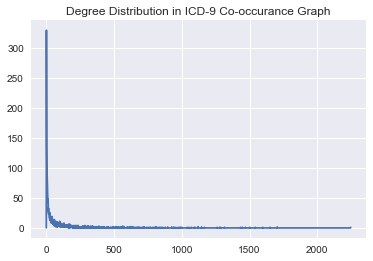

In [87]:
G = nx.Graph(final_edges)
print('Algebraic Connectivity: ', nx.algebraic_connectivity(G))
print('Average Clustering: ', nx.average_clustering(G))
plt.plot(nx.degree_histogram(G))
plt.title('Degree Distribution in ICD-9 Co-occurance Graph');

In [88]:
# examine top 10 most frequent edges
top_ix = np.array(list(edge_count.keys()))[np.argsort(list(edge_count.values()))][::-1]
freq_edges = [[icd_code_to_name[u], icd_code_to_name[v]] for u,v in top_ix[:10]]
dict(zip(map(tuple, freq_edges), [edge_count[tuple(x)] for x in top_ix[:10]]))

{('Crnry athrscl natve vssl', 'Hypertension NOS'): 6844,
 ('Atrial fibrillation', 'Hypertension NOS'): 5790,
 ('Atrial fibrillation', 'CHF NOS'): 5745,
 ('DMII wo cmp nt st uncntr', 'Hypertension NOS'): 5051,
 ('Crnry athrscl natve vssl', 'CHF NOS'): 4610,
 ('Hypertension NOS', 'CHF NOS'): 4126,
 ('Hyperlipidemia NEC/NOS', 'Hypertension NOS'): 4071,
 ('Crnry athrscl natve vssl', 'Hyperlipidemia NEC/NOS'): 3702,
 ('Esophageal reflux', 'Hypertension NOS'): 3209,
 ('DMII wo cmp nt st uncntr', 'CHF NOS'): 3209}

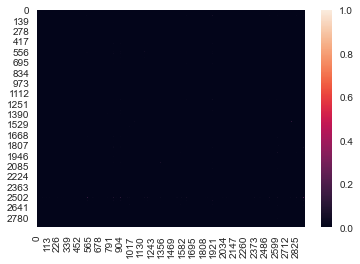

In [91]:
# define a co-occurence matrix where M[i,j] gives total co-occurences between node_list i,j 
M = np.zeros((len(node_list), len(node_list)))
node_to_index = dict(zip(node_list, np.arange(len(node_list))))
for e in final_edges:
    M[node_to_index[e[0]], node_to_index[e[1]]] += 1
M.shape
sns.heatmap((M/M.max()));

### Train poincare model on observed ICD relations

In [ ]:
# import modules within repository
sys.path.append('/Users/drew/Desktop/hyperbolic-learning/utils')
sys.path.append('/Users/drew/Desktop/hyperbolic-learning/utils/poincaré_embeddings')
from embed import *

# train poincare embeddings and save output embedding coordinates
fin = 'data/mimic-iii/mortality_pred/icd_occurrence_edges.csv' # input path with stored relations
fout = 'data/mimic-iii/mortality_pred/icd_occurrence_embeddings.csv' # output path to write embedding coordinates

# call function to train gensim's poincare embedding model
train_embeddings(input_path=fin, delimiter=',', output_path=fout, epochs=20, burn_in_alpha=0.01, 
                 batch_size=20, burn_in=10, alpha=0.1, negative=20)

INFO:gensim.models.poincare:loading relations from train data..
INFO:gensim.models.poincare:loaded 3413801 relations from train data, 2914 nodes
INFO:gensim.models.poincare:training model of size 2 with 1 workers on 3413801 relations for 20 epochs and 10 burn-in epochs, using lr=0.10000 burn-in lr=0.01000 negative=20
INFO:gensim.models.poincare:starting burn-in (10 epochs)----------------------------------------
INFO:gensim.models.poincare:training on epoch 1, examples #9980-#10000, loss: 59.91
INFO:gensim.models.poincare:time taken for 10000 examples: 3.88 s, 2580.14 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #19980-#20000, loss: 57.91
INFO:gensim.models.poincare:time taken for 10000 examples: 4.05 s, 2466.67 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #29980-#30000, loss: 56.42
INFO:gensim.models.poincare:time taken for 10000 examples: 4.06 s, 2466.08 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #39980-#

INFO:gensim.models.poincare:training on epoch 1, examples #459980-#460000, loss: 45.73
INFO:gensim.models.poincare:time taken for 10000 examples: 4.26 s, 2345.42 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #469980-#470000, loss: 45.67
INFO:gensim.models.poincare:time taken for 10000 examples: 4.57 s, 2188.49 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #479980-#480000, loss: 45.60
INFO:gensim.models.poincare:time taken for 10000 examples: 4.47 s, 2238.37 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #489980-#490000, loss: 45.58
INFO:gensim.models.poincare:time taken for 10000 examples: 4.13 s, 2419.02 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #499980-#500000, loss: 45.50
INFO:gensim.models.poincare:time taken for 10000 examples: 4.16 s, 2401.47 examples / s
INFO:gensim.models.poincare:training on epoch 1, examples #509980-#510000, loss: 45.62
INFO:gensim.models.poincare:time taken

In [ ]:
# store code ranges for each chapter
chapters = icd9.icd9Chapters
drop_lettered_chapters = False
if drop_lettered_chapters:
    drop1 = chapters.pop('Supplementary Classification Of External Causes Of Injury And Poisoning')
    drop2 = chapters.pop('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
chapter_name_range = {}
for k,v in chapters.items():
    chapter_name_range[k] = v[0] + '_' + v[1]
chapter_range_name = {v:k for k,v in chapter_name_range.items()}

# define mappings between chapter name & range to integer class labels
chapter_name_label = {}
for i, k in enumerate(chapters.keys()):
    chapter_name_label[k] = i
chapter_range_label = {k:i for i, k in enumerate(chapter_range_name)}

# define chapter range start and end three digit codes
node_labels = {}
chapter_intervals = []
chapter_labels = []
for k, v in chapter_range_label.items():
    start = k[:3]
    end = k[4:]
    chapter_labels.append(v)
    chapter_intervals.append([start, end])

# assign each node to its chapter class label
for node in node_list:
    start = node[:3]
    if start[0] == '0' or start <= '139':
        node_labels[node] = 0
    elif start[0] == 'V':
        node_labels[node] = 17
    elif start[0] == 'E':
        node_labels[node] = 18
    elif start == 'ICD':
        continue
    else:
        for i, interval in enumerate(chapter_intervals):
            if start >= interval[0] and start <= interval[1]:
                node_labels[node] = i

In [ ]:
# load embedding coordinates and prepare data for plotting in the poincare disk
emb = load_embeddings('data/mimic-iii/mortality_pred/icd_occurrence_embeddings.csv', delim=' ')
emb.head()
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
edge_list = final_edges
labels = emb[emb.node != 'ICD-9_Diagnoses']['node'].apply(lambda x: node_labels[x]).reset_index(drop=True)
chapter_label_range = {v:k for k,v in chapter_range_label.items()}

In [ ]:
# import cross library module
sys.path.append('/Users/drew/Desktop/vu-informatics/utils')
from poincare_viz_icd import *

# add labels for chapters and select only high level edges
chapter_emb = emb[emb.node.apply(lambda x: x in observed_chapters)]
chapter_emb_dict = dict(zip(chapter_emb.node.values, chapter_emb.iloc[:, 1:3].values))
chapter_edges = [e for e in edge_list if e[0] in observed_chapters or e[1] in observed_chapters]

plot_poincare_icd(emb, labels, edge_list=chapter_edges, add_labels=True, label_dict=chapter_emb_dict,
                  edge_frac=0.1, plot_frac=1, label_frac=0, legend_headers=chapter_label_range,
                  save=True, title='Learned from EHR Co-occurences');

### Evaluate Hyperbolic Embeddings

In [ ]:
# plot distance from center vs. node degree
radial_dist = []
degree_counts = []
for node in G.nodes():
    radial_dist.append(poincare_dist([0, 0], emb[emb['node'] == node].iloc[:,1:3]))
    degree_counts.append(G.degree(node))
plt.figure(figsize=(12,6))
print('correlation: ', np.abs(np.corrcoef(degree_counts, radial_dist)[0,1]))
plt.scatter(degree_counts, radial_dist);

In [ ]:
def within_chapter_distances(chapter_nodes, embedding_dict):
    # compute all pairwise hyperbolic distances
    D = poincare_distances(np.array([embedding_dict[x] for x in chapter_nodes]))
    mean_dist = D[D>0].mean()
    std_dev = D[D>0].std()
    return [mean_dist, std_dev]

In [ ]:
def between_chapter_distances(chapter_nodes, embedding, dist_matrix):
    # compute all pairwise hyperbolic distances
    embedding = embedding[embedding.node != 'ICD-9_Diagnoses'].reset_index(drop=True)
    in_group_indices = embedding[embedding.node.apply(lambda x: x in chapter_nodes)].index
    rows = np.arange(0, dist_matrix.shape[0])
    out_group_indices = list(set(rows).difference(in_group_indices))
    between_dists = [dist_matrix[ix, out_group_indices] for ix in in_group_indices]
    mean_dist = np.mean(between_dists)
    std_dev = np.std(between_dists)
    return [mean_dist, std_dev]

In [ ]:
within_means = []
within_stds = []
between_means = []
between_stds = []
emb_data = np.array(list(emb_dict.values()))
D = poincare_distances(emb_data)
D_symm = D.T + D
for i in range(len(np.unique(labels))):
    chapter_nodes = emb[emb.node != 'ICD-9_Diagnoses']['node'].values[labels == i]
    within_mean, within_std = within_chapter_distances(chapter_nodes, emb_dict)
    within_means.append(within_mean)
    within_stds.append(within_std)
    between_mean, between_std = between_chapter_distances(chapter_nodes, emb, D_symm)
    between_means.append(between_mean)
    between_stds.append(between_std)
np.mean(within_means)
np.mean(within_stds)
np.mean(between_means)
np.mean(between_stds)
np.mean(within_means) / np.mean(between_means)

### Train Euclidean Embeddings

Note: use cui2vec/R/glove_fit.R to fit GloVe embeddings with varying number of dimensions

In [ ]:
# save data frame as co-occurrence matrix to use with GloVe (text2vec) in R
pd.DataFrame(nx.adjacency_matrix(G).todense(), index=list(G.nodes())).to_csv('data/mimic-iii/mortality_pred/icd_occur_matrix.csv')

In [81]:
# load embeddings
glove_2 = pd.read_csv('data/mimic-iii/mortality_pred/glove_emb_2.csv')
glove_2['Unnamed: 0'] = list(G.nodes())
glove_2.rename(columns={'Unnamed: 0': 'node'}, inplace=True)
glove_2.head()
glove_2.shape

glove_10 = pd.read_csv('data/mimic-iii/mortality_pred/glove_emb_10.csv')
glove_10['Unnamed: 0'] = list(G.nodes())
glove_10.rename(columns={'Unnamed: 0': 'node'}, inplace=True)
glove_10.head()
glove_10.shape

glove_100 = pd.read_csv('data/mimic-iii/mortality_pred/glove_emb_100.csv')
glove_100['Unnamed: 0'] = list(G.nodes())
glove_100.rename(columns={'Unnamed: 0': 'node'}, inplace=True)
glove_100.head()
glove_100.shape

,node,X1,X2
0,40301,0.072959,0.241434
1,486,0.033929,0.023469
2,58281,0.397968,0.440246
3,5855,0.243230,0.001619
4,4254,0.143737,0.043921


(2912, 3)

,node,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,40301,0.225529,0.210034,0.297220,0.167567,0.181666,-0.067529,0.190856,-0.394909,-0.013458,-0.051145
1,486,-0.038294,0.059586,0.067501,-0.069599,-0.028638,-0.030173,0.051335,0.039690,0.024108,0.038452
2,58281,0.254651,0.435009,0.047343,-0.240237,0.386776,0.190925,-0.110365,0.403969,0.209565,-0.315361
3,5855,-0.125443,-0.447050,-0.455594,0.077367,0.117318,-0.227716,0.241036,0.069007,0.026541,0.096755
4,4254,-0.099124,0.074327,0.117942,-0.095616,0.121855,-0.026308,0.015600,0.066173,0.014568,-0.129413


(2912, 11)

,node,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
0,40301,0.246076,-0.163092,0.187113,-0.419886,0.087278,-0.247041,-0.332622,-0.416252,-0.364196,...,0.111610,-0.217349,-0.050255,-0.363898,0.159537,0.049124,0.273226,-0.014486,0.264415,-0.339484
1,486,0.028838,-0.149447,0.076668,0.147266,0.035793,-0.027597,-0.011047,-0.012884,0.041530,...,-0.123064,-0.179404,-0.150439,-0.153662,-0.076157,-0.148236,0.147942,0.038622,0.037619,0.123962
2,58281,-0.019761,0.068480,0.091650,0.287598,0.252340,-0.220640,0.100836,-0.056052,-0.428704,...,0.299836,0.014091,0.023331,-0.264018,0.198802,-0.347939,-0.324437,0.221079,0.270497,-0.085286
3,5855,0.239056,-0.345874,0.168877,0.132425,0.280265,0.267206,0.426090,-0.187866,-0.260666,...,-0.135454,-0.186808,-0.182770,0.409403,0.065099,-0.199538,-0.358427,0.301667,-0.198078,0.281448
4,4254,-0.286886,0.142627,-0.070064,0.134789,-0.131317,-0.264538,-0.169140,0.049800,0.100532,...,0.065720,0.070031,-0.118417,0.127201,-0.223965,0.301435,0.200001,-0.052080,0.254962,0.152952


(2912, 101)

In [83]:
from sklearn.metrics import pairwise_distances
emb = glove_2
emb_data = np.array(glove_2.iloc[:, 1:3])
emb_dict = dict(zip(glove_2.node.values, emb_data))
within_means = []
within_stds = []
between_means = []
between_stds = []
emb_data = np.array(list(emb_dict.values()))
D = pairwise_distances(emb_data)
D_symm = D.T + D
for i in range(len(np.unique(labels))):
    chapter_nodes = emb[emb.node != 'ICD-9_Diagnoses']['node'].values[labels == i]
    within_mean, within_std = within_chapter_distances(chapter_nodes, emb_dict)
    within_means.append(within_mean)
    within_stds.append(within_std)
    between_mean, between_std = between_chapter_distances(chapter_nodes, emb, D_symm)
    between_means.append(between_mean)
    between_stds.append(between_std)
np.mean(within_means)
np.mean(within_stds)
np.mean(between_means)
np.mean(between_stds)
np.mean(within_means) / np.mean(between_means)

1.05617213999967

0.5158026474121445

0.9549141023613378

0.4608663662207197

1.1060388964703092

In [84]:
emb = glove_10
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
within_means = []
within_stds = []
between_means = []
between_stds = []
emb_data = np.array(list(emb_dict.values()))
D = pairwise_distances(emb_data)
D_symm = D.T + D
for i in range(len(np.unique(labels))):
    chapter_nodes = emb[emb.node != 'ICD-9_Diagnoses']['node'].values[labels == i]
    within_mean, within_std = within_chapter_distances(chapter_nodes, emb_dict)
    within_means.append(within_mean)
    within_stds.append(within_std)
    between_mean, between_std = between_chapter_distances(chapter_nodes, emb, D_symm)
    between_means.append(between_mean)
    between_stds.append(between_std)
np.mean(within_means)
np.mean(within_stds)
np.mean(between_means)
np.mean(between_stds)
np.mean(within_means) / np.mean(between_means)

1.0724517450351896

0.5245278383479026

0.9621125495058325

0.464574838705821

1.1146842909242067

In [85]:
emb = glove_100
emb_data = np.array(emb.iloc[:, 1:3])
emb_dict = dict(zip(emb.node.values, emb_data))
within_means = []
within_stds = []
between_means = []
between_stds = []
emb_data = np.array(list(emb_dict.values()))
D = pairwise_distances(emb_data)
D_symm = D.T + D
for i in range(len(np.unique(labels))):
    chapter_nodes = emb[emb.node != 'ICD-9_Diagnoses']['node'].values[labels == i]
    within_mean, within_std = within_chapter_distances(chapter_nodes, emb_dict)
    within_means.append(within_mean)
    within_stds.append(within_std)
    between_mean, between_std = between_chapter_distances(chapter_nodes, emb, D_symm)
    between_means.append(between_mean)
    between_stds.append(between_std)
np.mean(within_means)
np.mean(within_stds)
np.mean(between_means)
np.mean(between_stds)
np.mean(within_means) / np.mean(between_means)

1.0806251744933904

0.5237114651117992

0.9761443918048751

0.4693012657609822

1.107034147371714